# Assignment 2A

**Name:** Nabilah Anuwar

**Student ID:** 31282016

In [39]:
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F
import numpy as np
import pandas as pd

# 1. Data Loading, Cleaning, Labelling, and Exploration (45%)

## 1.1 Data Loading

In [40]:
from pyspark import SparkConf
master = "local[*]"
app_name = "31282016 Assignment 2A"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [41]:
flightsRawDf = spark.read.csv("flight-delays/flight*.csv", header = True, inferSchema = True)

In [42]:
allColumnFlights = flightsRawDf.count()

## 1.2 Data Cleaning

### Part 1

In [43]:
schema1 = StructType([
    StructField("column_name", StringType()),
    StructField("no_of_row", IntegerType()),
    StructField("missing_percentage", FloatType())
])

def calc_miss(df, schema):
    col_name = df.columns
    total_col = df.count()
    result = []
    # https://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/
    total_miss = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
    
    for c in col_name:
        a_row = [c, total_miss[c], round((total_miss[c]/total_col)*100,2)]
        result.append(a_row)
        
    the_df = spark.createDataFrame(result, schema = schema).orderBy(col("missing_percentage").desc(), col("no_of_row").desc())
    return the_df

In [44]:
calc_miss(flightsRawDf, schema1).show(len(flightsRawDf.columns))

+-------------------+---------+------------------+
|        column_name|no_of_row|missing_percentage|
+-------------------+---------+------------------+
|CANCELLATION_REASON|   573213|             98.46|
|      AIRLINE_DELAY|   475831|             81.73|
|LATE_AIRCRAFT_DELAY|   475831|             81.73|
|      WEATHER_DELAY|   475831|             81.73|
|   AIR_SYSTEM_DELAY|   475831|             81.73|
|     SECURITY_DELAY|   475831|             81.73|
|       ELAPSED_TIME|    10455|               1.8|
|      ARRIVAL_DELAY|    10455|               1.8|
|           AIR_TIME|    10455|               1.8|
|            TAXI_IN|     9257|              1.59|
|       ARRIVAL_TIME|     9257|              1.59|
|          WHEELS_ON|     9257|              1.59|
|           TAXI_OUT|     8891|              1.53|
|         WHEELS_OFF|     8891|              1.53|
|    DEPARTURE_DELAY|     8633|              1.48|
|     DEPARTURE_TIME|     8633|              1.48|
|        TAIL_NUMBER|     1462|

#### CANCELLATION_REASON

This would require the flight to be cancelled. If it is not then it wouldn't be filled. This can be checked below.

In [45]:
flightsRawDf.select("CANCELLED").filter(col("CANCELLED")==0).count()

573213

The number above matched on why there are empty rows in the `CANCELLATION_REASON` as the flights listed here isn't cancelled.

#### AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY, AIR_SYSTEM_DELAY, SECURITY_DELAY

Seems to be empty simultaneously. They are columns based on input not calculations. Thus we can say they are missing due to human error.

#### ELAPSED_TIME

`ELAPSED_TIME` have a dependency on `AIR_TIME`, thus if `AIR_TIME` is missing it is possible that this will cause nulls.

#### ARRIVAL_DELAY

This column have a dependency on `ARRIVAL_TIME` and `SCHEDULED_ARRIVAL`, thus null `ARRIVAL_TIME` can cause nulls in this column

#### AIR_TIME

Though not on calculation based, the information is still based on `WHEELS_ON` and `WHEELS_OFF` thus having nulls in these columns can result in nulls in `AIR_TIME`

#### TAXI_IN, ARRIVAL_TIME, WHEELS_ON

`ARRIVAL_TIME` have dependencies on the other two. If there are nulls in these columns the resulting output will most likely be null. There are equal amount of nulls here which means the missing row does not have any information on any of these columns.

#### TAXI_OUT, WHEELS_OFF

Though not a calculated column, `TAXI_OUT` still depends on `WHEELS_OFF` column. Time duration elapsed between departure cannot be calculated without `WHEELS_OFF` time.

#### DEPARTURE_DELAY, DEPARTURE_TIME

Without `DEPARTURE_TIME`, `DEPARTURE_DELAY` cannot be calculated, again, even though it is not a calculated column.

#### TAIL_NUMBER

This column could be missing at random as it fully depend on human input. 

### Part 2

In [46]:
x = 10

def find_removed_columns(x, flightsRawDf):
    data = calc_miss(flightsRawDf, schema1)
    filtered = data.filter(col("missing_percentage") > x).select("column_name").collect()
    removedColumns = [str(row['column_name']) for row in filtered]
    return removedColumns

In [47]:
def eliminate_columns(removedColumns, flightsRawDf):
    flightsRawDf = flightsRawDf.drop(*[str(x) for x in removedColumns])
    return flightsRawDf

In [48]:
q122 = eliminate_columns(find_removed_columns(x, flightsRawDf), flightsRawDf)
print(f"The number of columns are {len(q122.columns)}")
print(f"The number of rows are {q122.count()}")

The number of columns are 25
The number of rows are 582184


In [49]:
flightsDf = q122.na.drop("any")
print(f"The number of columns are {len(flightsDf.columns)}")
print(f"The number of rows are {flightsDf.count()}")

The number of columns are 25
The number of rows are 571729


## 1.3 Data Labelling

### Part 1

In [50]:
flightsDf = flightsDf.withColumn("binaryArrDelay", when(col("ARRIVAL_DELAY")> 0,1).otherwise(0)).withColumn("binaryDeptDelay", when(col("DEPARTURE_DELAY")>0,1).otherwise(0))

Here we classify:

* negative values or less than 5 as *early* or 0

* the value between 5 and 20 (inclusive) as *on time* or 1

* positive values or more than 20 as *late* or 2

In [51]:
flightsDf = flightsDf.withColumn("multiClassArrDelay", when(col("ARRIVAL_DELAY")> 20,2).when(col("ARRIVAL_DELAY") < 5,0).otherwise(1))\
.withColumn("multiCassDeptDelay", when(col("DEPARTURE_DELAY")> 20,2).when(col("DEPARTURE_DELAY") < 5,0).otherwise(1))

### Part 2

In [52]:
def classify_this(df, column):
    the_col = [ x[column] for x in df.select(column).collect()]
    
    q3, q1 = np.percentile(the_col, [75, 25])
    min_val = min(the_col)
    max_val = max(the_col)
    
    if column == "ARRIVAL_DELAY":
        new_col = "multiClassArrDelay"
    elif column == "DEPARTURE_DELAY":
        new_col = "multiCassDeptDelay"
        
    result = df.withColumn(new_col, when(col(column)> q3,2).when(col(column) <= q1,0).otherwise(1))
    
    return result

In [53]:
flightsDf = classify_this(flightsDf, "ARRIVAL_DELAY")
flightsDf = classify_this(flightsDf, "DEPARTURE_DELAY")

The question had asked us to group the data to 3 groups so the number of bins is 3. Now to determine the interval, we use the quartile function. With this we can see in what interval that most of data falls, which is between Q3 and Q1 of the data. Anything below will be put as early because it is smaller in the scale if time. Moreover, anything over Q3 is over where most of the data falls.

## 1.4 Data Exploration / Exploratory Analysis

### Part 1

In [54]:
round(flightsDf.toPandas().describe(),2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay,multiClassArrDelay,multiCassDeptDelay
count,571729.0,571729.00,571729.00,571729.00,571729.00,571729.00,571729.00,571729.00,571729.00,571729.00,...,571729.00,571729.00,571729.00,571729.00,571729.0,571729.0,571729.00,571729.00,571729.00,571729.00
mean,2015.0,6.54,15.71,3.93,2160.62,1328.70,1334.71,9.32,16.08,1357.02,...,7.43,1494.01,1477.35,4.47,0.0,0.0,0.37,0.37,0.97,0.97
std,0.0,3.40,8.77,1.98,1752.19,483.32,496.15,37.43,8.92,497.70,...,5.61,506.26,525.30,39.79,0.0,0.0,0.48,0.48,0.71,0.72
min,2015.0,1.00,1.00,1.00,1.00,1.00,1.00,-48.00,1.00,1.00,...,1.00,1.00,1.00,-82.00,0.0,0.0,0.00,0.00,0.00,0.00
25%,2015.0,4.00,8.00,2.00,727.00,916.00,921.00,-5.00,11.00,935.00,...,4.00,1110.00,1059.00,-13.00,0.0,0.0,0.00,0.00,0.00,0.00
50%,2015.0,7.00,16.00,4.00,1678.00,1325.00,1330.00,-2.00,14.00,1343.00,...,6.00,1520.00,1512.00,-5.00,0.0,0.0,0.00,0.00,1.00,1.00
75%,2015.0,9.00,23.00,6.00,3202.00,1730.00,1740.00,7.00,19.00,1754.00,...,9.00,1918.00,1917.00,8.00,0.0,0.0,1.00,1.00,1.00,1.00
max,2015.0,12.00,31.00,7.00,7438.00,2359.00,2400.00,1670.00,200.00,2400.00,...,202.00,2400.00,2400.00,1665.00,0.0,0.0,1.00,1.00,2.00,2.00


### Part 2

Here we define that categorical values are values that can be divided into groups rather than presenting them in a continuous respresentation.

Before going further, we have assume that all string type columns are categorical columns. This is because they are supposedly name of a given entity for its representation. These columns are:

* `AIRLINE`

* `TAIL_NUMBER`

* `ORIGIN_AIRPORT`

* `DESTINATION_AIRPORT`

There are several columns that are numerical values that is suppose to be ordinal, in this case categorical

* `YEAR` - they represent when the event happened

* `MONTH` - they when the event happened

* `DAY` - they represent when the event happened

* `DAY_OF_WEEK` - they represent when the event happened

* `FLIGHT_NUMBER` - flight identifier, not a measure of some sort

* `DIVERTED` - boolean of whether the plane diverted or now

* `CANCELLED` - boolean of whether the plane cancelled or not

* `binaryArrDelay` - boolean if the plane was late at arrival or not

* `binaryDeptDelay` - boolean if the plane was late at departure or not

* `multiClassArrDelay` - grouping of whether the plane was early, on time, or late upon arrival

* `multiCassDeptDelay` - grouping of whether the plane was early, on time, or late upon departure

The rest are values of time or time difference thus is not categorical.

In [55]:
# define list
chosen = ['YEAR','MONTH','DAY','DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER','TAIL_NUMBER','ORIGIN_AIRPORT',\
          'DESTINATION_AIRPORT','DIVERTED','CANCELLED','binaryArrDelay','binaryDeptDelay','multiClassArrDelay',\
          'multiCassDeptDelay']

In [56]:
def desc_cat(df, cols):
    new_cols = ["col_name", "no_unique", "highest_cat", "highest_no"]
    data = []
    for c in cols:
        new_col = [c]
        col = [x[c] for x in df.select(c).collect()]
        uniq = list(set(col))
        new_col.append(len(uniq))
        high_cat = []
        ren = range(0,len(uniq))
        for u in uniq:
            high_cat.append(col.count(u))
        max_val = max(high_cat)
        ind = high_cat.index(max_val)
        new_col.append(str(uniq[ind]))
        new_col.append(max_val)
        data.append(new_col)
    new_data = spark.createDataFrame(data, new_cols)
    return new_data

In [57]:
desc_cat(flightsDf, chosen).show()

+-------------------+---------+-----------+----------+
|           col_name|no_unique|highest_cat|highest_no|
+-------------------+---------+-----------+----------+
|               YEAR|        1|       2015|    571729|
|              MONTH|       12|          7|     51415|
|                DAY|       31|         13|     19407|
|        DAY_OF_WEEK|        7|          4|     86227|
|            AIRLINE|       14|         WN|    123912|
|      FLIGHT_NUMBER|     6691|        469|       397|
|        TAIL_NUMBER|     4802|     N480HA|       398|
|     ORIGIN_AIRPORT|      625|        ATL|     34506|
|DESTINATION_AIRPORT|      624|        ATL|     34087|
|           DIVERTED|        1|          0|    571729|
|          CANCELLED|        1|          0|    571729|
|     binaryArrDelay|        2|          0|    362674|
|    binaryDeptDelay|        2|          0|    360501|
| multiClassArrDelay|        3|          1|    278992|
| multiCassDeptDelay|        3|          1|    275565|
+---------

### Part 3

**Part A**

<AxesSubplot:xlabel='MONTH'>

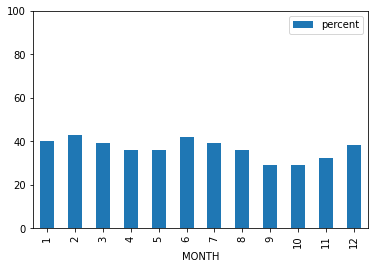

In [58]:
q143a = flightsDf.groupBy("MONTH").agg(F.sum(col("binaryArrDelay")).alias("sum"), F.count(col("MONTH")).alias("total"))\
.withColumn("percent", F.round((col("sum")/col("total"))*100)).orderBy("MONTH").toPandas()

q143a.plot.bar("MONTH", "percent", ylim = [0,100])

**Part B**

<AxesSubplot:xlabel='DAY_OF_WEEK'>

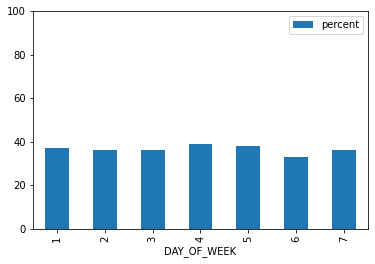

In [59]:
q143b = flightsDf.groupBy("DAY_OF_WEEK").agg(F.sum(col("binaryArrDelay")).alias("sum"), F.count(col("DAY_OF_WEEK")).alias("total"))\
.withColumn("percent", F.round((col("sum")/col("total"))*100)).orderBy("DAY_OF_WEEK").toPandas()

q143b.plot.bar("DAY_OF_WEEK", "percent", ylim = [0,100])

**Part C**

<AxesSubplot:xlabel='AIRLINE'>

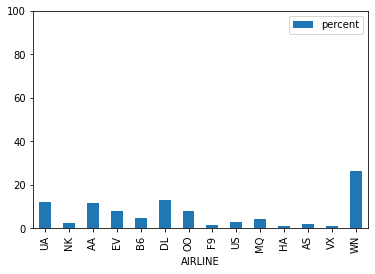

In [60]:
q143c = flightsDf.groupBy("AIRLINE").agg(F.sum(col("binaryDeptDelay")).alias("sum"))
summed = sum([x["sum"] for x in q143c.select("sum").collect()])
q143c = q143c.withColumn("percent", F.round((col("sum")/summed)*100, 1)).toPandas()

q143c.plot.bar("AIRLINE", "percent", ylim = [0,100])

# 2. Feature extraction and ML Training

## 2.1 Discuss the feature selection and prepare the feature columns

### Part 1

In [61]:
flight_df = flightsDf.toPandas()
flight_df.corr()[-4:]

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,binaryArrDelay,binaryDeptDelay,multiClassArrDelay,multiCassDeptDelay
binaryArrDelay,NaN,-0.053875,-0.006956,-0.011677,0.013503,0.125526,0.159455,0.426323,0.277381,0.162454,...,0.144976,0.110632,0.097964,0.548828,NaN,NaN,1.000000,0.554035,0.732012,0.557576
binaryDeptDelay,NaN,-0.037683,-0.003501,-0.001282,-0.052005,0.186498,0.224339,0.477504,0.052396,0.220059,...,-0.013248,0.163634,0.145414,0.450235,NaN,NaN,0.554035,1.000000,0.548113,0.736514
multiClassArrDelay,NaN,-0.056135,-0.006481,-0.018390,0.020182,0.122817,0.158870,0.454000,0.277196,0.161887,...,0.143900,0.102210,0.090546,0.603048,NaN,NaN,0.732012,0.548113,1.000000,0.576861
multiCassDeptDelay,NaN,-0.027900,-0.003792,-0.003706,-0.064574,0.167293,0.209007,0.514770,0.054746,0.204854,...,-0.030751,0.149397,0.130082,0.480174,NaN,NaN,0.557576,0.736514,0.576861,1.000000


Categorical values will be put through as it is, they will recognize there are some patterns to it and apply accordingly.

**YEAR**

We can see from section 1.4.2 that there are only one single value within this database for `YEAR`, thus we can omit that as all data will have the same value. This means that this value won't impact towards our result.

**MONTH, DAY, DAY_OF_WEEK, FLIGHT_NUMBER, SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, DISTANCE**

These column have an almost 0 value for pearson correlation coefficient, thus will not be included.

**SCHEDULED_DEPARTURE, DEPARTURE_TIME, WHEELS_ON, SCHEDULED_ARRIVAL, ARRIVAL_TIME, WHEELS_OFF, TAXI_OUT, TAXI_IN**

Will be included as it has a higher p-value than others. Though it doesn't seem to be sugnificantly large, we chose those that is closer to |0.1|. 

`WHEELS_ON` and `WHEELS_OFF` have quite a significant value for the predition of labels related to departure delay. However, its relation with the arrival delay is close to |0.1| and they do not seem to have a large difference.

`TAXI_OUT` and `TAXI_IN` have quite a significant value for the predition of labels related to arrival delay, thus will be included in the prediction of arrival delay labels. 

Though these 4 seem to not relate with their other group, we include them as they highly affect one group. Hopefully this will benefit in searching for an accurate model for both of the labels related to both departure and arrival delay.

**DEPARTURE_DELAY, ARRIVAL_DELAY**

These column is directly related to the creation of the labels, thus will be exempted. Including these columns will give the answer to the labels straightforwardly. Here we are trying to predict using other columns that indirectly affect the label columns.

**DIVERTED, CANCELLED**

Has only one value, thus will not be affected to the outcome and will be excluded. This is similar to the case of `YEAR` where there is only one value which means every value have an equal footing and it does not significantly affect any other column's result.

### Part 2

In [62]:
dept = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WHEELS_ON', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_OFF']
arr = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WHEELS_ON', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_OFF', 'TAXI_OUT', 'TAXI_IN']

cols = arr+["binaryArrDelay", "binaryDeptDelay", "multiClassArrDelay", "multiCassDeptDelay"]

feature_df = flightsDf.select(cols)

## 2.2 Preparing any Spark ML Transformers/ Estimators for features and models

### Part 1

We do not need to transform strings to numerical vectors using StringIndexer as we have no string type column included.

We merge columns to a feature vector columns using VectorAssembler

In [63]:
# import libraries
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [64]:
incold = dept
incola = arr

stage_1d = VectorAssembler(inputCols = incold, outputCol = "features")
stage_1a = VectorAssembler(inputCols = incola, outputCol = "features")

### Part 2

In [65]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol

class Seasoning(Transformer, HasInputCol, HasOutputCol):
    def __init__(self, inputCol = None, outputCol = None):
        super(Seasoning, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
        
    def get_input_col(self):
        return self.inputCol
    
    def get_output_col(self):
        return self.outputCol
    
    def _transform(self, dataset):
        input_col = self.get_input_col()
        output_col = self.get_output_col()
        new_data = dataset.withColumn(output_col,(when((col(input_col) >= 3) & (col(input_col) <= 5), "Spring")\
                                     .when((col(input_col) >= 6) & (col(input_col) <= 8), "Summer")\
                                     .when((col(input_col) >= 9) & (col(input_col) <= 11), "Autumn")\
                                     .when((col(input_col) == 12) | (col(input_col) == 1) | (col(input_col) == 2), "Winter")\
                                     .otherwise(None)))
        return new_data

### Part 3

In [66]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_dept = DecisionTreeClassifier(featuresCol = "features", labelCol = "binaryDeptDelay")
dt_arr = DecisionTreeClassifier(featuresCol = "features", labelCol = "binaryArrDelay")

In [67]:
from pyspark.ml.classification import GBTClassifier

gbt_dept = GBTClassifier(featuresCol = "features", labelCol = "binaryDeptDelay")
gbt_arr = GBTClassifier(featuresCol = "features", labelCol = "binaryArrDelay")

### Part 4

In [68]:
from pyspark.ml.classification import NaiveBayes

nb_arr = NaiveBayes(featuresCol = "features", labelCol = "multiClassArrDelay")

### Part 5

In [69]:
from pyspark.ml import Pipeline

arr_model1 = Pipeline(stages = [stage_1a, dt_arr])
arr_model2 = Pipeline(stages = [stage_1a, gbt_arr])
arr_model3 = Pipeline(stages = [stage_1a, nb_arr])

dept_model1 = Pipeline(stages = [stage_1d, dt_dept])
dept_model2 = Pipeline(stages = [stage_1d, gbt_dept])

## 2.3 Preparing the training and testing data

In [70]:
train, test = feature_df.randomSplit([0.8, 0.2], seed=31282016)

## 2.4 Training and evaluating models

In [71]:
def get_stats(df, col):
    # Calculate the elements of the confusion matrix
    TN = df.filter(f'prediction = 0 AND {col} = 0').count()
    TP = df.filter(f'prediction = 1 AND {col} = 1').count()
    FN = df.filter(f'prediction = 1 AND {col} = 0').count()
    FP = df.filter(f'prediction = 0 AND {col} = 1').count()
    
    # calculate metrics by the confusion matrix
    accuracy = (TP + TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (FN+TP)
    f1 = (2*precision*recall)/(precision + recall)

    #WRITE CODE : Display the various metrics calculated above
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

### Part 1

#### Part A, B, C

**Decision Trees**

In [72]:
arr_dt = arr_model1.fit(train)
arr_dtx = arr_dt.transform(test)
arr_dtx.groupBy('binaryArrDelay', 'prediction').count().show()
get_stats(arr_dtx, 'binaryArrDelay')

+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|28060|
|             0|       0.0|67505|
|             1|       1.0|13678|
|             0|       1.0| 5283|
+--------------+----------+-----+

Accuracy:  0.7088608700207814
Precision:  0.32771095883846857
Recall:  0.7213754548810717
F1:  0.45068287780688315


In [73]:
dept_dt = dept_model1.fit(train)
dept_dtx = dept_dt.transform(test)
dept_dtx.groupBy('binaryDeptDelay', 'prediction').count().show()
get_stats(dept_dtx, 'binaryDeptDelay')

+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|36815|
|              0|       0.0|70716|
|              1|       1.0| 5433|
|              0|       1.0| 1562|
+---------------+----------+-----+

Accuracy:  0.6649057855858058
Precision:  0.128597803446317
Recall:  0.7766976411722659
F1:  0.22066080458136184


**Gradient Boosted Tree**

In [74]:
arr_gbt = arr_model2.fit(train)
arr_gbtx = arr_gbt.transform(test)
arr_gbtx.groupBy('binaryArrDelay', 'prediction').count().show()
get_stats(arr_gbtx, 'binaryArrDelay')

+--------------+----------+-----+
|binaryArrDelay|prediction|count|
+--------------+----------+-----+
|             1|       0.0|20864|
|             0|       0.0|68958|
|             1|       1.0|20874|
|             0|       1.0| 3830|
+--------------+----------+-----+

Accuracy:  0.7843808392854025
Precision:  0.5001197949111121
Recall:  0.8449643782383419
F1:  0.6283374973661238


In [75]:
dept_gbt = dept_model2.fit(train)
dept_gbtx = dept_gbt.transform(test)
dept_gbtx.groupBy('binaryDeptDelay', 'prediction').count().show()
get_stats(dept_gbtx, 'binaryDeptDelay')

+---------------+----------+-----+
|binaryDeptDelay|prediction|count|
+---------------+----------+-----+
|              1|       0.0|24107|
|              0|       0.0|69973|
|              1|       1.0|18141|
|              0|       1.0| 2305|
+---------------+----------+-----+

Accuracy:  0.7693798788048128
Precision:  0.42939310736602915
Recall:  0.8872640125207865
F1:  0.5787156665709637


#### Part D

Out of accuracy, precision, recall, and F1, we need to look more towards F1. This is because F1 is the model's weighted average accuracy. In our data there may be an imbalance in the True and False, so if we have a lot of True and we got have all values to be True then out accuracy will still be quite high despite False being False Positive. Thus, F1-Score weighs the accuracy based on the amount of True and False of the group. Making it a better and more objective accuracy calculation. 

#### Part E

**binaryArrDelay**

From the two model we can see there is a huge difference of around 20% in their F1-Score, as we said we need to focus on its F1-Score. 

Looking plainly at the accuracy we can see there is already a difference of 9%, which compared to the F1-Score is nothing. We may be able to pass this as a "not so different" models. However, looking further to its precision, Decision Trees dropped to 32.5% while Gradient Boosted Tree stays at 53%. That means when Decision Trees predict yes, it is only correct 32.5% of the time. Gradient Booster Tree recall is quite high with 85% while Decision Tree not so far with 72%. Gradient Booster Tree again become the higher scoring one in predicting how often it is right when a value is supposed to be True.

Thus with the ups and downs in the accuracy, precision, and recall their scores are still quite similar with Gradient Boosted Tree scoring higher. Thus, their F1-Score does represent them correctly, with Gradient Boosted Tree as a better predictor.

**binaryDeptDelay**

As we discussed before, F1-Score is the most important measurement for the models. Here Gradient Boosted Tree is significantly higher than Decision Trees in its F1-Score with a 36% difference. It is obvious from first look that Gradient Boosted Tree prevail in the other measurements. Accuracy and Recall has around 10% difference, similar to the case before, with Gradient Boosted Tree scoring higher. However, the huge difference, again, can be seen in its precision where Decision Trees is as low as 13%. This may be the reason on why Decision Trees' F1-Score is significantly lower than of that Gradient Boosted Tree.

**Overall**

Gradient Boosted Tree model is the better model.

**Persist Better Model**

###### Already write it so couldn't rewrite

arr_gbt.save("Binary Arrival Delay")
dept_gbt.save("Binary Departure Delay")

#### Part F

In [79]:
def get_leaf(model, incol):
    string = model.stages[-1].toDebugString
    for i, feat in enumerate(incol):
        string = string.replace('feature ' + str(i), feat)
    print(string)

In [80]:
get_leaf(arr_gbt, incola)

GBTClassificationModel: uid = GBTClassifier_e0125353d958, numTrees=20, numClasses=2, numFeatures=8
  Tree 0 (weight 1.0):
    If (TAXI_OUT <= 24.5)
     If (DEPARTURE_TIME <= 1224.5)
      If (TAXI_IN <= 20.5)
       If (TAXI_OUT <= 16.5)
        If (SCHEDULED_DEPARTURE <= 1250.5)
         Predict: -0.6235299745660684
        Else (SCHEDULED_DEPARTURE > 1250.5)
         Predict: 0.8384458077709611
       Else (TAXI_OUT > 16.5)
        If (SCHEDULED_DEPARTURE <= 1250.5)
         Predict: -0.34681052099584697
        Else (SCHEDULED_DEPARTURE > 1250.5)
         Predict: 0.8745387453874539
      Else (TAXI_IN > 20.5)
       If (TAXI_IN <= 30.5)
        If (TAXI_OUT <= 16.5)
         Predict: 0.005835156819839533
        Else (TAXI_OUT > 16.5)
         Predict: 0.36666666666666664
       Else (TAXI_IN > 30.5)
        If (TAXI_IN <= 32.5)
         Predict: 0.4394904458598726
        Else (TAXI_IN > 32.5)
         Predict: 0.7645283018867924
     Else (DEPARTURE_TIME > 1224.5)
      If (SCHE

**GBT Arrival Delay**

1. `TAXI_OUT` 

2. `DEPARTURE_TIME` or `WHEELS_OFF`

3. `TAXI_IN` 

These columns are responsible for the decision making of the model as the top 3 columns that was chosen first in the model decision making. With `TAXI_OUT` as the determinant of where a result will be going depending on the value of that column, which can lead next to either `DEPARTURE_TIME` or `WHEELS_OFF`. Both of these path will then lead to `TAXI_IN`.

In [81]:
get_leaf(dept_gbt, incold)

GBTClassificationModel: uid = GBTClassifier_a3594a68c080, numTrees=20, numClasses=2, numFeatures=6
  Tree 0 (weight 1.0):
    If (DEPARTURE_TIME <= 1058.5)
     If (SCHEDULED_DEPARTURE <= 1120.5)
      If (WHEELS_ON <= 1000.5)
       If (WHEELS_OFF <= 733.5)
        If (SCHEDULED_DEPARTURE <= 679.5)
         Predict: -0.6866976744186046
        Else (SCHEDULED_DEPARTURE > 679.5)
         Predict: -0.8235728801034546
       Else (WHEELS_OFF > 733.5)
        If (SCHEDULED_DEPARTURE <= 719.5)
         Predict: 0.4603564843269822
        Else (SCHEDULED_DEPARTURE > 719.5)
         Predict: -0.6699501087373673
      Else (WHEELS_ON > 1000.5)
       If (SCHEDULED_ARRIVAL <= 1014.5)
        If (ARRIVAL_TIME <= 1035.5)
         Predict: 0.17174280879864637
        Else (ARRIVAL_TIME > 1035.5)
         Predict: 0.8967838444278234
       Else (SCHEDULED_ARRIVAL > 1014.5)
        If (SCHEDULED_DEPARTURE <= 1052.5)
         Predict: -0.44151689338569977
        Else (SCHEDULED_DEPARTURE > 1052.5)


**GBT Departure Delay**

1. `DEPARTURE_TIME`

2. `SCHEDULED_DEPARTURE`

3. `ARRIVAL_TIME`

The model will look upon `DEPARTURE_TIME` where it then goes through the list appropriately to make decisions.

#### Part G

It would help if we try different number of trees to find the ideal number of trees for the model. A tree model would increase its accuracy as the number of trees grow, this would mean there is more coverage. However, when the number of trees is too large, the effectiveness and quality of the result lowers. This may be caused to creating unnecessary paths which stray further from the answer as it goes beyond the ideal point. Therefore, finding the correct number of trees is very important.

We can definitely improve by trying out different patterns of features. Though the p-value for those that we did not include was low, there might be a slight chance that it can improve the accuracy. We also did not include `TAXI_IN` and `TAXI_OUT` in the classification of the Departure Delay. In their p-value, though low, it had some effect towards the Arrival Delay, therefore there might be some impact that was not discoverable by the p-value.

Relying on pearson coefficient correlation was also a mistake. To know whether a feature is fitting will need more than just one type of test, but multiple one. Pearson is one of the basic general correlation test, which may not be as accurate as we expected.

Another is rebalancing the data. We should have the same amount of True and False to get a fair amount of training for both results. With this we may be able to minimize the gap between accuracy and F1-Score. We may also able to improve precision if we have equal amount of data for each binary. In https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html it says that the balance of the data is very important to how well the model do.

### Part 2

#### Part A, B, C

In [82]:
arr_nb = arr_model3.fit(train)
arr_nbx = arr_nb.transform(test)
arr_nbx.groupBy('multiClassArrDelay', 'prediction').count().show()
get_stats(arr_nbx, 'multiClassArrDelay')

+------------------+----------+-----+
|multiClassArrDelay|prediction|count|
+------------------+----------+-----+
|                 2|       1.0|12388|
|                 1|       0.0|18261|
|                 0|       2.0| 5224|
|                 0|       0.0|15379|
|                 1|       2.0|12496|
|                 2|       2.0| 9940|
|                 1|       1.0|25189|
|                 2|       0.0| 5180|
|                 0|       1.0|10469|
+------------------+----------+-----+

Accuracy:  0.5854137204536928
Precision:  0.5797238204833142
Recall:  0.7064052947445174
F1:  0.6368256055013399


#### Part D

As we discussed before we consider F1-Score a better measure as it tries to measure with the weighted average of all the data in mind. Especially this is a multiclass variable, therefore there are more types of result that can cause discrepancy in how the data is divided. Therefore, F1-Score would me more accurate than accusracy itself.


#### Part E

One part to improve Naive Bayes that we already did is removing any nulls or empty data. Though Naive Bayes can handle missing dat, it is always best to optimize the data by getting rid of as many nulls as much as possible.

Using Log probabilities can help in Naive Bayes. A quote from https://machinelearningmastery.com/better-naive-bayes/

*"because to make a prediction in Naive Bayes we need to know which class has the larger probability (rank) rather than what the specific probability was."*

Having Log probabilities can help with this as using Log probabilities will help you avoid getting small numbers due to joint calculations. This is further supported by https://www.baeldung.com/cs/naive-bayes-classification-performance

*"Multiplying very small numbers will lead to even smaller numbers. It is difficult to precisely store and compare these very small numbers. We face these problems when working with probability values."*

Similar to my response before, we can always try a number of different feature combination. There were no categorical values included. We can try to see if there was a difference in our expectation and our result in Pearson correlation coefficient. 

Another point made by https://machinelearningmastery.com/better-naive-bayes/ is that Naive Bayes does not need a lot of data to learn. 

*"Given that interactions between attributes are ignored in the model, we do not need examples of these interactions and therefore generally less data than other algorithms, such as logistic regression."*

Therefore what we need is not a large data but just a small data with enough data for each of its class.

https://www.baeldung.com/cs/naive-bayes-classification-performance mentioned how we should categorize continuous data instead of representing them as a column with real numbers. The Naive Bayes derive itself from the z-table, where normal distribution lies and it uses descriptive statistics for that. In our grouping previously, we have used quartiles to categorize our values. We can also use this to other columns to further improve the accuracy of the Naive Bayes.